In [1]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics_flat
from particle import literals as lp
from fcc_python_tools import plotting
import tensorflow as tf
import zfit
import random

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

In [2]:
path = "/eos/experiment/fcc/ee/tmp/testmatching/"
mode = "Bd2KstTauTauTAUHADNU"

file = uproot.open(path+f"events_{mode}.root")
tree = file['events']
events = tree.arrays(library="ak", how="zip")

n_keep = 100000
events = events[:n_keep] 

Relate reco particles with their MC info, to get the parent PDG ID (for truth-matching) and the production vertex (to calculate flight vectors for the $B$ and $\tau$'s) 

In [3]:
events["RP","pdg"] = events["MC","pdg"][events["RP","MC_parentindex"]]
#Get the production vertex of the track, smeared by 5%
for v in ["x","y","z"]:
    events["RP",f"vertex_{v}"] = events["MC",f"vertex_{v}"][events["RP","MC_index"]] 
#Separation of vertex from PV
events["RP","PVsep"] = np.sqrt(events["RP",f"vertex_x"]**2 + events["RP",f"vertex_y"]**2 + events["RP",f"vertex_z"]**2)

In [4]:
rp = events["RP"]

#Pions
pi_cut = abs(rp["mass"] - lp.pi_plus.mass/1000.) < 1e-4
pions = rp[pi_cut]
p_cut = pions["p"] > 1.
pions = pions[p_cut]

#Kaons
k_cut = abs(rp["mass"] - lp.K_plus.mass/1000.) < 1e-4
kaons = rp[k_cut]
p_cut = kaons["p"] > 1.
kaons = kaons[p_cut]

Make $K^*$

In [5]:
Kst = ak.cartesian({"k": kaons, "pi": pions})
Kst_cut = np.sign(Kst["k","charge"]) != np.sign(Kst["pi","charge"])
Kst = Kst[Kst_cut]

PDG_K_m = lp.K_plus.mass/1000.
PDG_pi_m = lp.pi_plus.mass/1000.
Kst["mass"] = kinematics_flat.mass([Kst["k"], Kst["pi"]], [PDG_K_m, PDG_pi_m])

PDG_Kst_m = lp.Kst_892_0.mass/1000.
Kst_window = 0.1
Kst_cut = abs(Kst["mass"] - PDG_Kst_m) < Kst_window
Kst = Kst[Kst_cut]

#Truth-matching
Kst_parent_cut_pi = abs(Kst["pi"]["pdg"]) == abs(lp.Kst_892_0.pdgid)
Kst_parent_cut_k = abs(Kst["k"]["pdg"]) == abs(lp.Kst_892_0.pdgid)
Kst_parent_cut_all = np.logical_and(Kst_parent_cut_pi, Kst_parent_cut_k)
Kst = Kst[Kst_parent_cut_all]
#Ensure kaon and pion come from the same K*
Kst_parent_cut_kpi = Kst["pi","MC_parentindex"] == Kst["k","MC_parentindex"]
Kst = Kst[Kst_parent_cut_kpi]

for comp in ["x","y","z"]:
    Kst[f"p{comp}"] = Kst["k",f"p{comp}"] + Kst["pi",f"p{comp}"]
Kst["p"] = np.sqrt(Kst["px"]**2 + Kst["py"]**2 + Kst["pz"]**2)
Kst["e"] = np.sqrt(Kst["p"]**2 + Kst["mass"]**2)

Make $\tau \to 3\pi$ 

In [6]:
tau = ak.combinations(pions,3)
tau["pi_1"], tau["pi_2"], tau["pi_3"] = ak.unzip(tau)

#Charge cut on the pions
tau_charge_cut_1 = np.sign(tau["pi_1","charge"]) != np.sign(tau["pi_3","charge"]) 
tau_charge_cut_2 = np.sign(tau["pi_2","charge"]) != np.sign(tau["pi_3","charge"])
tau_charge_cut = np.logical_and(tau_charge_cut_1, tau_charge_cut_2)

tau = tau[tau_charge_cut]

PDG_pi_m = lp.pi_plus.mass/1000.
tau["mass"] = kinematics_flat.mass([tau["pi_1"], tau["pi_2"], tau["pi_3"]], [PDG_pi_m, PDG_pi_m, PDG_pi_m])
tau_m_low_cut_val = 3*PDG_pi_m
tau_m_high_cut_val = lp.tau_plus.mass/1000.
tau_m_low_cut = tau["mass"] >= tau_m_low_cut_val
tau_m_high_cut = tau["mass"] <= lp.tau_plus.mass/1000.
tau_m_cut = np.logical_and(tau_m_low_cut, tau_m_high_cut)
tau = tau[tau_m_cut]

#Truth-matching
tau_parent_cut_pi1 = abs(tau["pi_1"]["pdg"]) == abs(lp.tau_plus.pdgid)
tau_parent_cut_pi2 = abs(tau["pi_2"]["pdg"]) == abs(lp.tau_plus.pdgid) 
tau_parent_cut_pi3 = abs(tau["pi_3"]["pdg"]) == abs(lp.tau_plus.pdgid)
tau_parent_cut_12 = np.logical_and(tau_parent_cut_pi1, tau_parent_cut_pi2)
tau_parent_cut_all = np.logical_and(tau_parent_cut_12, tau_parent_cut_pi3)
tau = tau[tau_parent_cut_all]
#Ensure pions come from the same tau
tau_parent_cut_12 = tau["pi_1","MC_parentindex"] == tau["pi_2","MC_parentindex"]
tau_parent_cut_13 = tau["pi_1","MC_parentindex"] == tau["pi_3","MC_parentindex"]
tau_parent_cut = np.logical_and(tau_parent_cut_12, tau_parent_cut_13)
tau = tau[tau_parent_cut]
tau["charge"] = tau["pi_1","charge"] + tau["pi_2","charge"] + tau["pi_3","charge"]

Make combination of two $\tau$ candidates

In [7]:
tt = ak.combinations(tau,2)
tt["tau_1"], tt["tau_2"] = ak.unzip(tt)
tt_charge_cut = tt["tau_1","charge"] != tt["tau_2","charge"]
tt = tt[tt_charge_cut]

Combine $K^*$ and $\tau\tau$ to form a $B$ candidate

In [8]:
B = ak.cartesian({"Kst": Kst, "tt": tt})

B["mass"] = kinematics_flat.mass([B["Kst","k"],
                                  B["Kst","pi"],
                                  B["tt","tau_1","pi_1"],
                                  B["tt","tau_1","pi_2"],
                                  B["tt","tau_1","pi_3"],
                                  B["tt","tau_2","pi_1"],
                                  B["tt","tau_2","pi_2"],
                                  B["tt","tau_2","pi_3"]
                                 ],
                                 [PDG_K_m,
                                  PDG_pi_m,
                                  PDG_pi_m,
                                  PDG_pi_m,
                                  PDG_pi_m,
                                  PDG_pi_m,
                                  PDG_pi_m,
                                  PDG_pi_m
                                 ])

B_M_cut = B["mass"] < lp.B_0.mass/1000.
B = B[B_M_cut]                       

Flight components for the $B$ and the two $\tau$ candidates

In [9]:
for v in ["x","y","z"]:
    #B flight based on end vertex of the K*, assuming PV is at origin
    B[f"FD_{v}"] = B["Kst","k",f"vertex_{v}"]
    #Tau flight from difference between tau decay vertex and B
    for tau in ["1","2"]:
        B["tt",f"tau_{tau}",f"FD_{v}"] = B["tt",f"tau_{tau}","pi_1",f"vertex_{v}"] - B[f"FD_{v}"]
B["FD"] = np.sqrt(B["FD_x"]**2 + B["FD_y"]**2 + B["FD_z"]**2)
for tau in ["1","2"]:
    B["tt",f"tau_{tau}","FD"] = np.sqrt(B["tt",f"tau_{tau}","FD_x"]**2 + B["tt",f"tau_{tau}","FD_y"]**2 + B["tt",f"tau_{tau}","FD_z"]**2)
    

$3\pi$ momentum components

In [10]:
for tau in ["1","2"]:
    for comp in ["x","y","z"]:
        B["tt",f"tau_{tau}",f"p{comp}"] = B["tt",f"tau_{tau}","pi_1",f"p{comp}"] + B["tt",f"tau_{tau}","pi_2",f"p{comp}"] + B["tt",f"tau_{tau}","pi_3",f"p{comp}"]
    B["tt",f"tau_{tau}","p"] = np.sqrt(B["tt",f"tau_{tau}","px"]**2 + B["tt",f"tau_{tau}","py"]**2 + B["tt",f"tau_{tau}","pz"]**2)
    B["tt",f"tau_{tau}","e"] = np.sqrt(B["tt",f"tau_{tau}","p"]**2 + B["tt",f"tau_{tau}","mass"]**2)
        

Angle between $\tau$ flight vectors and the $3\pi$ momenta

In [11]:
for tau in ["1","2"]:
    B["tt",f"tau_{tau}","costheta"] = (B["tt",f"tau_{tau}","px"]*B["tt",f"tau_{tau}","FD_x"] + B["tt",f"tau_{tau}","py"]*B["tt",f"tau_{tau}","FD_y"] + B["tt",f"tau_{tau}","pz"]*B["tt",f"tau_{tau}","FD_z"])/(B["tt",f"tau_{tau}","p"]*B["tt",f"tau_{tau}","FD"])
    B["tt",f"tau_{tau}","theta"] = np.arccos(B["tt",f"tau_{tau}","costheta"])

$\tau$ momentum solutions using this angle

In [12]:
PDG_tau_m = lp.tau_plus.mass/1000.
for tau in ["1","2"]:
    B["tt",f"tau_{tau}","quad"] = B["tt",f"tau_{tau}","e"]*np.sqrt((PDG_tau_m**2 - B["tt",f"tau_{tau}","mass"]**2)**2 - 4*PDG_tau_m**2*B["tt",f"tau_{tau}","p"]**2*(np.sin(B["tt",f"tau_{tau}","theta"]))**2)
    B["tt",f"tau_{tau}","p_reco_plus"] = ((B["tt",f"tau_{tau}","mass"]**2 + PDG_tau_m**2)*B["tt",f"tau_{tau}","p"]*np.cos(B["tt",f"tau_{tau}","theta"]) + B["tt",f"tau_{tau}","quad"])/(2.*(B["tt",f"tau_{tau}","e"]**2 - B["tt",f"tau_{tau}","p"]**2*(np.cos(B["tt",f"tau_{tau}","theta"]))**2))     
    B["tt",f"tau_{tau}","p_reco_minus"] = ((B["tt",f"tau_{tau}","mass"]**2 + PDG_tau_m**2)*B["tt",f"tau_{tau}","p"]*np.cos(B["tt",f"tau_{tau}","theta"]) - B["tt",f"tau_{tau}","quad"])/(2.*(B["tt",f"tau_{tau}","e"]**2 - B["tt",f"tau_{tau}","p"]**2*(np.cos(B["tt",f"tau_{tau}","theta"]))**2))     
    B["tt",f"tau_{tau}","e_reco_plus"] = np.sqrt(B["tt",f"tau_{tau}","p_reco_plus"]**2 + PDG_tau_m**2)
    B["tt",f"tau_{tau}","e_reco_minus"] = np.sqrt(B["tt",f"tau_{tau}","p_reco_minus"]**2 + PDG_tau_m**2)

/eos/user/d/dhill/.local/lib/python3.7/site-packages/awkward1/_connect/_numpy.py:101: RuntimeWarning: invalid value encountered in sqrt
  *[nplike.asarray(x) for x in inputs], **kwargs


Resolve momentum components using $\tau$ flight

In [13]:
for tau in ["1","2"]:
    for sol in ["plus","minus"]:
        for comp in ["x","y","z"]:
            B["tt",f"tau_{tau}",f"p{comp}_reco_{sol}"] = B["tt",f"tau_{tau}",f"p_reco_{sol}"] * (B["tt",f"tau_{tau}",f"FD_{comp}"]/B["tt",f"tau_{tau}","FD"])


$B$ solutions - 4 in total due to two $\tau$'s

In [14]:
for sol1 in ["plus","minus"]:
    for sol2 in ["plus","minus"]:
        for comp in ["px","py","pz","e"]:
            B[f"{comp}_reco_{sol1}_{sol2}"] = B["Kst",comp] + B["tt","tau_1",f"{comp}_reco_{sol1}"] + B["tt","tau_2",f"{comp}_reco_{sol2}"]
        B[f"p_reco_{sol1}_{sol2}"] = np.sqrt(B[f"px_reco_{sol1}_{sol2}"]**2 + B[f"py_reco_{sol1}_{sol2}"]**2 + B[f"pz_reco_{sol1}_{sol2}"]**2)
        B[f"mass_reco_{sol1}_{sol2}"] = np.sqrt(B[f"e_reco_{sol1}_{sol2}"]**2 - B[f"p_reco_{sol1}_{sol2}"]**2)


Calculate angle between the $B$ momentum solution and the $B$ flight

In [15]:
for sol1 in ["plus","minus"]:
    for sol2 in ["plus","minus"]:
        B[f"costheta_{sol1}_{sol2}"] = (B[f"px_reco_{sol1}_{sol2}"]*B["FD_x"] + B[f"py_reco_{sol1}_{sol2}"]*B["FD_y"] + B[f"pz_reco_{sol1}_{sol2}"]*B["FD_z"])/(B[f"p_reco_{sol1}_{sol2}"]*B["FD"])
        B[f"theta_{sol1}_{sol2}"] = np.arccos(B[f"costheta_{sol1}_{sol2}"])

/eos/user/d/dhill/.local/lib/python3.7/site-packages/awkward1/_connect/_numpy.py:101: RuntimeWarning: invalid value encountered in arccos
  *[nplike.asarray(x) for x in inputs], **kwargs


Loop over $B$ candidates, and find minimum angle for each one. Take the corresponding mass solution

In [16]:
mass_reco_best = []

#Loop over events
for i in range(0,len(B)):
    #Loop over B candidates in the event
    for j in range(0,len(B[i])):
        #Check if valid angle exists for the B candidate
        if(B["theta_plus_plus"][i][j] and not np.isnan(B["theta_plus_plus"][i][j])):
            
            min_angle = np.pi
            best_sol = ""
            for sol1 in ["plus","minus"]:
                for sol2 in ["plus","minus"]:
                    if(B[f"theta_{sol1}_{sol2}"][i][j] < min_angle):
                        min_angle = B[f"theta_{sol1}_{sol2}"][i][j]
                        best_sol = f"{sol1}_{sol2}"
            mass_reco_best.append(B[f"mass_reco_{best_sol}"][i][j])

Fit the $B$ peak with zfit

In [18]:
low = 5.2
high = 5.35
obs = zfit.Space('mB', limits=(low, high))

#PDF
rand = random.randint(0,999)
mu = zfit.Parameter(f"mu_{rand}", lp.B_0.mass/100., low, high)
sigma = zfit.Parameter(f"sigma_{rand}", 0.04, 0., 0.1)
alphaL = zfit.Parameter(f"alphaL_{rand}", 0.2, 0., 5.)
nL = zfit.Parameter(f"nL_{rand}", 10., 0., 200.)
alphaR = zfit.Parameter(f"alphaR_{rand}", -0.2, -5., 0.)
nR = zfit.Parameter(f"nR_{rand}", 10., 0., 200.)
frac = zfit.Parameter(f"frac_{rand}", 0.5, 0., 1.)

pdf_sigL = zfit.pdf.CrystalBall(obs=obs, mu=mu, sigma=sigma, alpha=alphaL, n=nL)
pdf_sigR = zfit.pdf.CrystalBall(obs=obs, mu=mu, sigma=sigma, alpha=alphaR, n=nR)
pdf = zfit.pdf.SumPDF([pdf_sigL, pdf_sigR], frac)

In [19]:
data_np = ak.to_numpy(mass_reco_best)
data_low_cut = data_np >= low
data_high_cut = data_np <= high
data_cut = np.logical_and(data_low_cut, data_high_cut)
data_np = data_np[data_cut]
data = zfit.Data.from_numpy(obs=obs, array=data_np)

In [20]:
nll = zfit.loss.UnbinnedNLL(model=pdf, data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
param_errors = result.hesse()

print("Fit function minimum:", result.fmin)
print("Fit converged:", result.converged)
print("Fit full minimizer information:", result.info)

params = result.params
print(params)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -4310                      │       Ncalls = 913 (913 total)       │
│ EDM = 0.000101 (Goal: 0.001)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
Fit function minimum: -4310.434396904182
Fit converged: True
Fit full minimizer information: {'n_eval': 913, 'n_iter': 913, 'original': FMin(fval=-4310.434396904182, edm=0.00010112145417146988, tolerance=1.0, nfcn=913, ncalls=913, up=0.5, i

/usr/local/bin/start_ipykernel.py:12: UserWarning: The function <function Space.area at 0x7f776969ad40> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('mB',), axes=None, limits=(array([[5.2]]), array([[5.35]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.


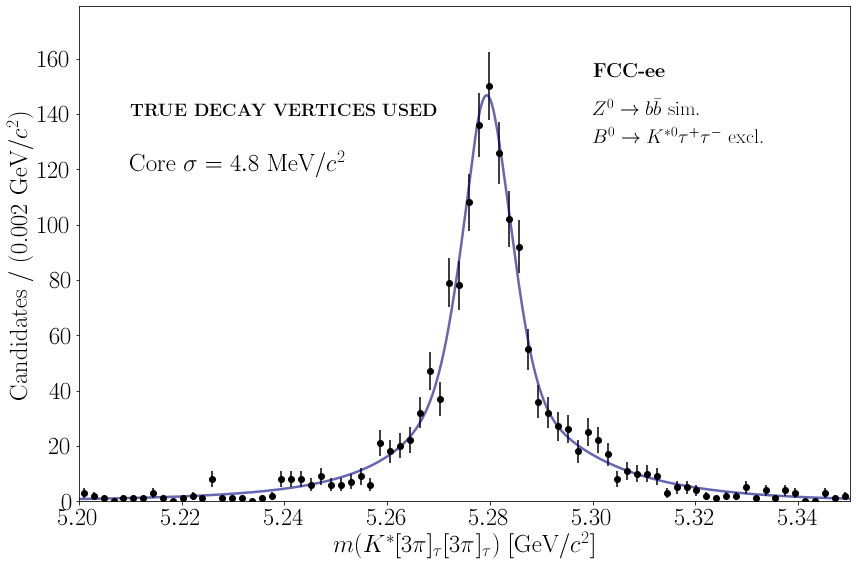

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
n = len(data_np)
bins = 2*int(np.sqrt(n))
bin_w = (high - low)/bins
units = "GeV/$c^2$"
counts, bin_edges = np.histogram(data_np, bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', color='k')
x_plot = np.linspace(low, high, num=1000)
y_plot_tot = zfit.run(pdf.pdf(x_plot, norm_range=obs))
plt.plot(x_plot, y_plot_tot*len(data_np)/bins*obs.area(), color='navy', linewidth=2.5, alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.3f GeV/$c^2$)" % bin_w,fontsize=25)
plt.xlabel("$m(K^* [3\pi]_\\tau [3\pi]_\\tau)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.text(5.3,0.9*ymax,"\\textbf{FCC-ee}",fontsize=20)
plt.text(5.3,0.82*ymax,"$Z^0 \\to b\\bar{b}$ sim.",fontsize=20)
plt.text(5.3,0.76*ymax,"$B^0 \\to K^{*0} \\tau^+ \\tau^-$ excl.",fontsize=20)
plt.text(5.21,0.82*ymax,"\\textbf{TRUE DECAY VERTICES USED}",fontsize=18)
sigma_val = 1000.*params[sigma]['value']
plt.text(5.21,0.7*ymax,"Core $\\sigma = %.1f$ MeV/$c^2$" % sigma_val,fontsize=25)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/{mode}_B_M_reco_fit.pdf")

Plot the $B$ flight distance from the PV 

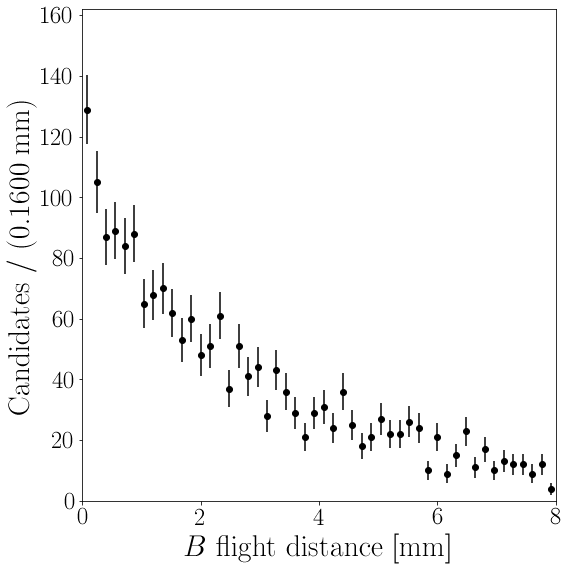

In [25]:
plotting.errorbar_hist(B,"FD",f"{mode}_B","$B$ flight distance","mm",0.,8.,50)